
# wFunction

Ce petit module python a pour objectif de créer un circuit quantique préparant les qubits dans une distribution de votre choix.

Pour ce faire, une transformation linéaire est appliquée au domaine de la distribution pour l'amener dans le domaine binaire $[0,2^n-1]$ ou $n$ est le nombre de qubits utilisé. La fonction d'onde préparée est donc $\sum_i f(i)|i \rangle$ ou $i$ est l'état des qubits lorsque lue en binaire et $f(i)$ est la distribution cible sur le domaine binaire évalué à $i$.

 Les fonctions du module normalisent automatiquement la distribution.

## Installation

### Quimb

wFunction dépend de la bibliothèque de manipulation de tenseur Quimb.
Malheureusement, il est possible que la version de quimb disponible sur pypa ne soit pas suffisamment à jour. Si c'est le cas, utilisez la commande suivante: 
    
    pip install git+https://github.com/jcmgray/quimb.git

### Conda    

L'installation avec conda n'est pas testée. Comme il s'agit d'un projet purement en python, il devrait fonctionner sans problème.

### Installation

Télécharger le dépôt git, puis à partir du dossier du projet, saisissez la commande
    
    pip install ./
    


## Utilisation

### préparation de distribution

Dans la cellule suivante, on importe wFunction, qiskit et numpy et on définit la distribution. Noté que la distribution dans cet exemple à deux paramètres: mu et sigma. Nous allons devoir les fixer avant de donner cette fonction à wFunction.

In [1]:
%%capture
import wFunction as wf
import qiskit as qs
import numpy as np
from scipy.stats import lognorm as scplog
def lognorm(x,mu,sigma):
    return scplog.pdf(np.exp(-mu)*x,sigma )

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Une fois la fonction définie, on crée un registre quantique avec le nombre de qubits désiré, et on appelle *Generate_f_circuit*.
Noté qu'on fixe les paramètres de la distribution en la plaçant dans un lambda.
Les arguments sont: la distribution, la précision de la discrétisation intermédiaire de la fonction, la fidélité du circuit, le nombre de qubits, le domaine de la fonction, le registre quantique du circuit, le nombre maximal de couches du circuit et, finalement, le nom du circuit.

In [28]:
%%capture
nqbit = 7
domain = [0,7]
threeqb = qs.QuantumRegister(nqbit)
circ = wf.Generate_f_circuit(lambda x:lognorm(x,1,1),MPS_precision=1e-14,Gate_precision=1e-2,nqbit=nqbit,domain=domain,register=threeqb,Nlayer=500,name="lognormal")



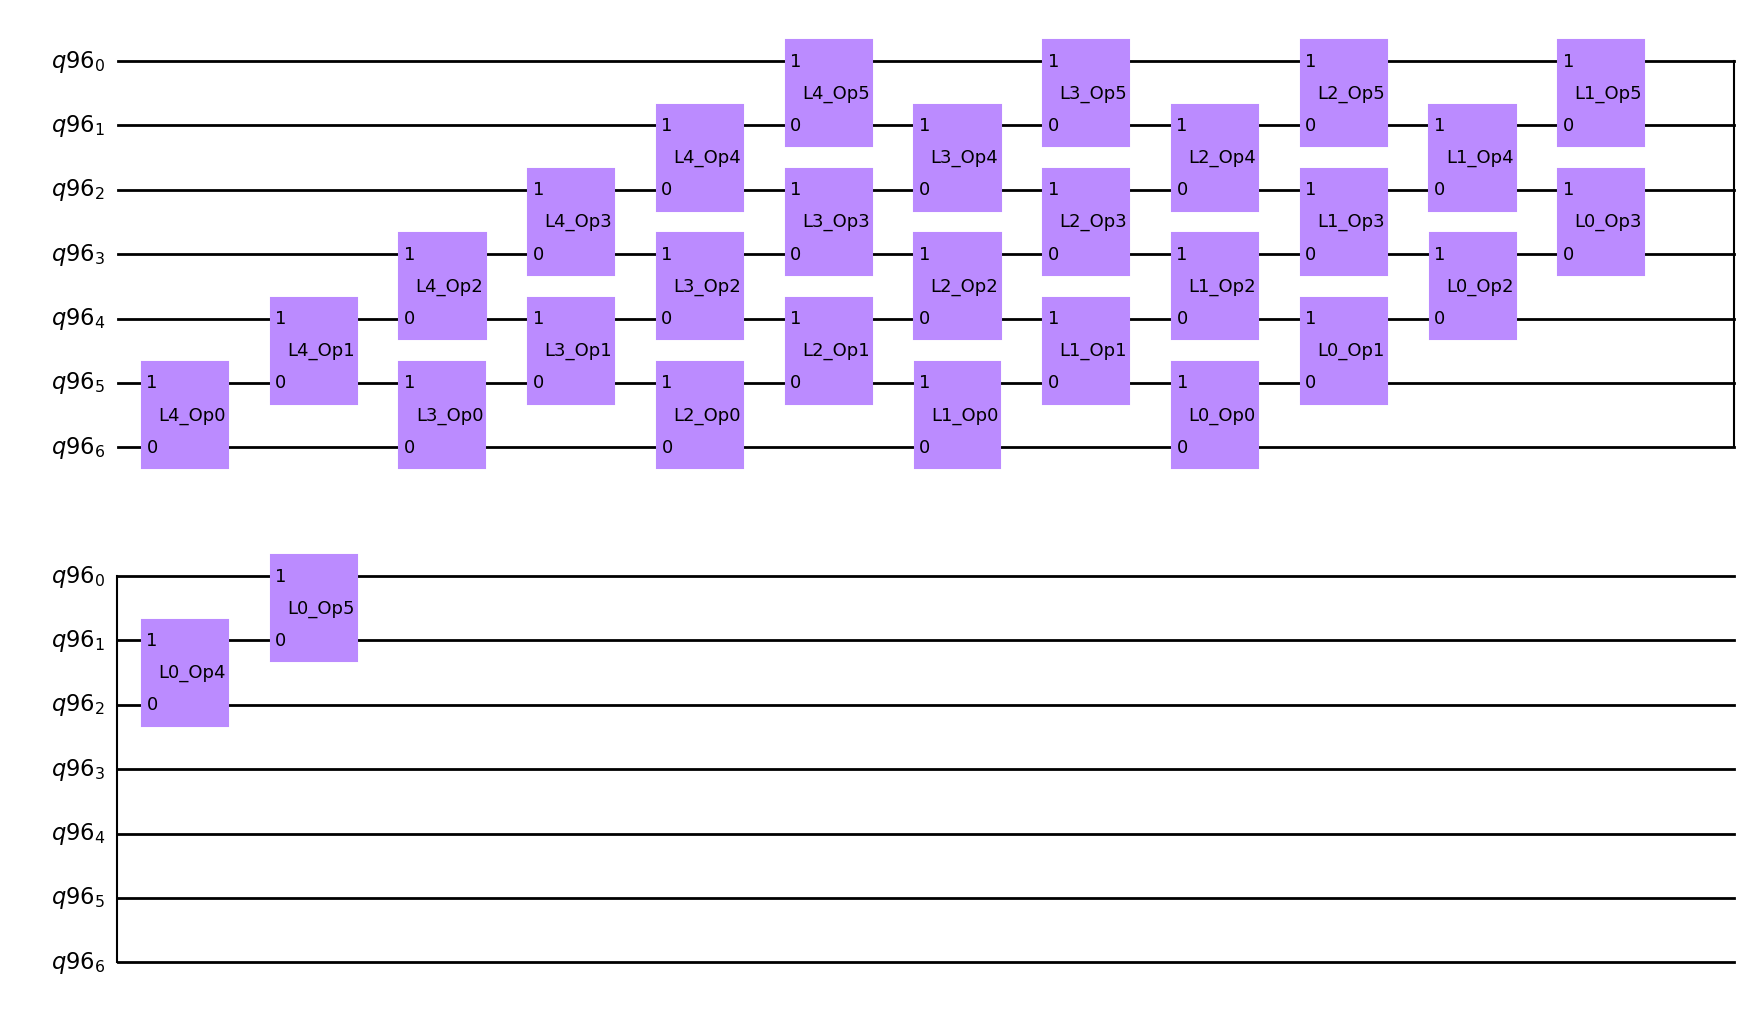

In [29]:
circ.draw('mpl')

Finalement, on peut observer le résultat d'une simulation.

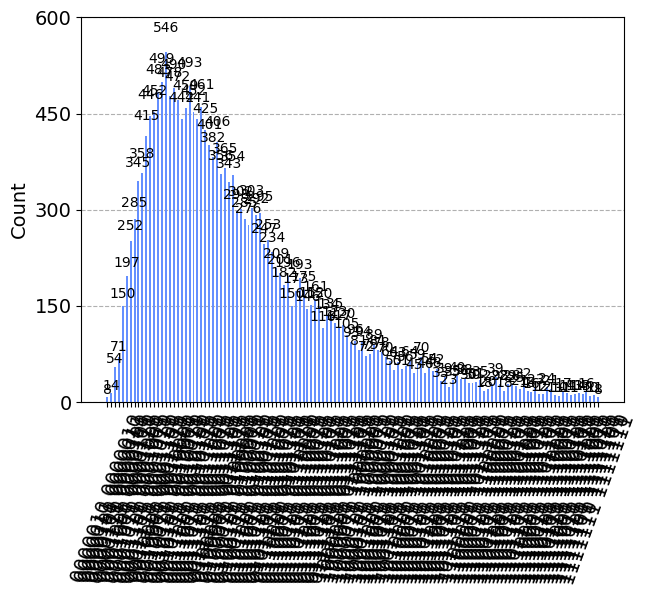

In [31]:
from qiskit import transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

circ.measure_all()
simulator = QasmSimulator()
compiled_circuit = transpile(circ, simulator)
shots = 20000
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

Si l’on désire plutôt que les probabilités des états correspondent à une distribution particulière, il faut fournir la racine carrée de la distribution.

error:  0.20961584702731886
error:  0.007075751333089413


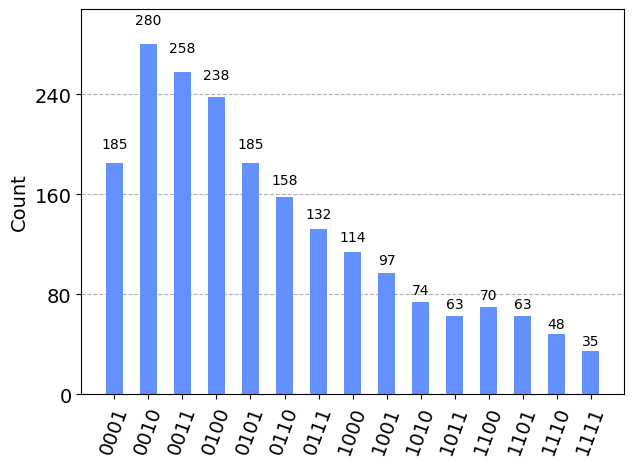

In [5]:
threeqb = qs.QuantumRegister(nqbit)
circ = wf.Generate_f_circuit(lambda x:np.sqrt(lognorm(x,1,1)),MPS_precision=1e-14,Gate_precision=1e-2,nqbit=nqbit,domain=[0,7],register=threeqb,Nlayer=20,name="lognormal")
circ.measure_all()
simulator = QasmSimulator()
compiled_circuit = transpile(circ, simulator)
shots = 2000
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)

### Qubitization de fonction

L'objectif de cette fonctionnalité est d'implémenter approximativement un opérateur
$G|x\rangle|0\rangle = g(x)|x\rangle|0\rangle + \sqrt{1-g^2(x)}|x\rangle|1\rangle$
pour une fonction $g(x)$ spécifié par l'utilisateur. Cet opérateur nécissite donc un qubit ancillaire . Ce genre de construction est apparenté à la qubitization d'opérateur.

Quelques usages possible:
- Étant donné un état $|\psi\rangle = \sum_x f(x)|x\rangle$, la moyenne pondéré $\sum_x |f(x)g(x)|^2$ peut être calculé en mesurant la probabilité de trouvé le qubit ancillaire dans l'état $|0\rangle$
- Pour un opérateur classiquement diagonalisable $O$, la fonction $g(x)$ serait le spectre de valeur propres et l'opérateur qubitizé est $ Q = (T^\dagger \otimes I_{2\times 2})G(T\otimes I_{2\times 2})$ ou T est l'opérateur unitaire diagonalisant $O$. Il existe des algorithmes pour obtenir la qubitization d'une somme à partir de la qubitization des termes de la somme. 

In [6]:
# %%capture
from qiskit_aer.primitives import Sampler,Estimator
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.providers.aer.aerprovider import AerProvider
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister
import matplotlib.pyplot as plt
nqbits = 8


In [25]:
circ = wf.qubitize_scalar(lambda x:lognorm(x,1,1),nqbits,[0,7],256,5e-3,cpt_rotations_matrices=wf.scalarQubitization.get_rotation_matrices)
C0 = QuantumCircuit(nqbits)
for i in range(nqbits-1):
    C0.h(i)

domain = [0,7]

C1 = C0.compose(circ,[*range(nqbits)])
C1.measure_all()
sim = AerSimulator()
tcirc = transpile(C1,sim,["rz","ecr","x","sx"])
sampler = Sampler(run_options={'shots':None}) #compute exactly instead of simulating shot noise
estimator = Estimator()

job = sampler.run(tcirc)
result = job.result()
data = np.zeros(2**nqbits)
x = np.linspace(*domain,2**(nqbits-1))


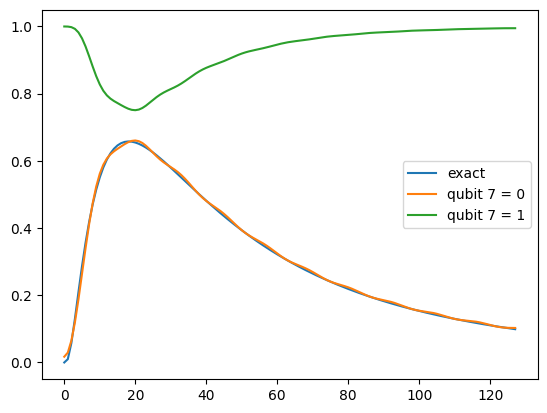

In [26]:
plt.plot(lognorm(x,1,1),label="exact")
for key in result.quasi_dists[0]:
    data[int(key)] = result.quasi_dists[0][key]
plt.plot(np.sqrt(data[:2**(nqbits-1)]*2**(nqbits-1)),label="qubit {} = 0".format(nqbits-1))
plt.plot(np.sqrt(data[2**(nqbits-1):]*2**(nqbits-1)),label ="qubit {} = 1".format(nqbits-1))

plt.legend()
plt.show()

Construire de tel opérateur est plus exigent que simplement préparé un état.
Il en résulte typiquement des circuit plus profond que dans le premier cas.

In [27]:
circ.decompose(reps=10).depth()

1219